# Multiple Run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

from utils import *
from calibrators import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter

## Functions

In [3]:
def group_data(
    df: pd.DataFrame,
    group_columns=[
        "username",
        "deviceName",
        "position",
        "distance",
        "targetPointX",
        "targetPointY",
    ],
) -> pd.DataFrame:
    # Columns to compute the median
    # Exclude group columns
    median_columns = [col for col in df.columns if col not in group_columns]

    # Grouping by specified columns and computing the median of the rest of the columns
    return df.groupby(group_columns)[median_columns].median().reset_index()

In [4]:
def create_split(calib_data, min_count=3, test_size=0.3):
    stratify_labels = [
        f"{cd.target_point[0]}_{cd.target_point[1]}" for cd in calib_data
    ]

    # Check distribution of stratification labels to ensure there's enough data for each category
    label_distribution = Counter(stratify_labels)

    # It's important that no label has too few samples to be split correctly
    # Adjust `min_count` based on your data size and the results of the distribution printout
    valid_indices = [
        i
        for i, label in enumerate(stratify_labels)
        if label_distribution[label] >= min_count
    ]

    # Filter data and labels to include only those that have enough samples
    filtered_data = [calib_data[i] for i in valid_indices]
    filtered_labels = [stratify_labels[i] for i in valid_indices]

    # Split data using train_test_split from scikit-learn, stratifying by the filtered labels
    return train_test_split(
        filtered_data, test_size=test_size, stratify=filtered_labels
    )

In [ ]:
def train_and_evaluate(
    extract_features: callable,
    train_data: List[CalibrationData],
    test_data: List[CalibrationData],
):
    lrc = LinearRegressionCalibrator(train_data, extract_features)
    return lrc, lrc.evaluate(test_data)

## Setup

In [14]:
df = load_df("data")
print("Dataframe size:", df.shape)
display(df.head())

Dataframe size: (900, 63)


,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,229.150642,146.014301,0.999920,...,0.031501,0.030555,0.025464,1.0,-0.107358,-0.088746,0.935463,1.349115,-0.681568,0.239772
1,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.180792,145.479826,0.999916,...,0.031501,0.030555,0.025464,1.0,-0.107400,-0.088713,0.935594,1.330942,-0.702563,0.239077
2,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.020193,146.354776,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107197,-0.088691,0.935635,1.337107,-0.709690,0.248199
3,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,231.099802,146.935916,0.999912,...,0.031501,0.030555,0.025464,1.0,-0.107069,-0.088685,0.935711,1.337563,-0.713248,0.263629
4,victor,iPad Mini 6th,Middle,Regular,1.715694e+09,0.0,0.0,230.052845,149.130141,0.999914,...,0.031501,0.030555,0.025464,1.0,-0.107005,-0.088807,0.935693,1.375624,-0.703335,0.269881


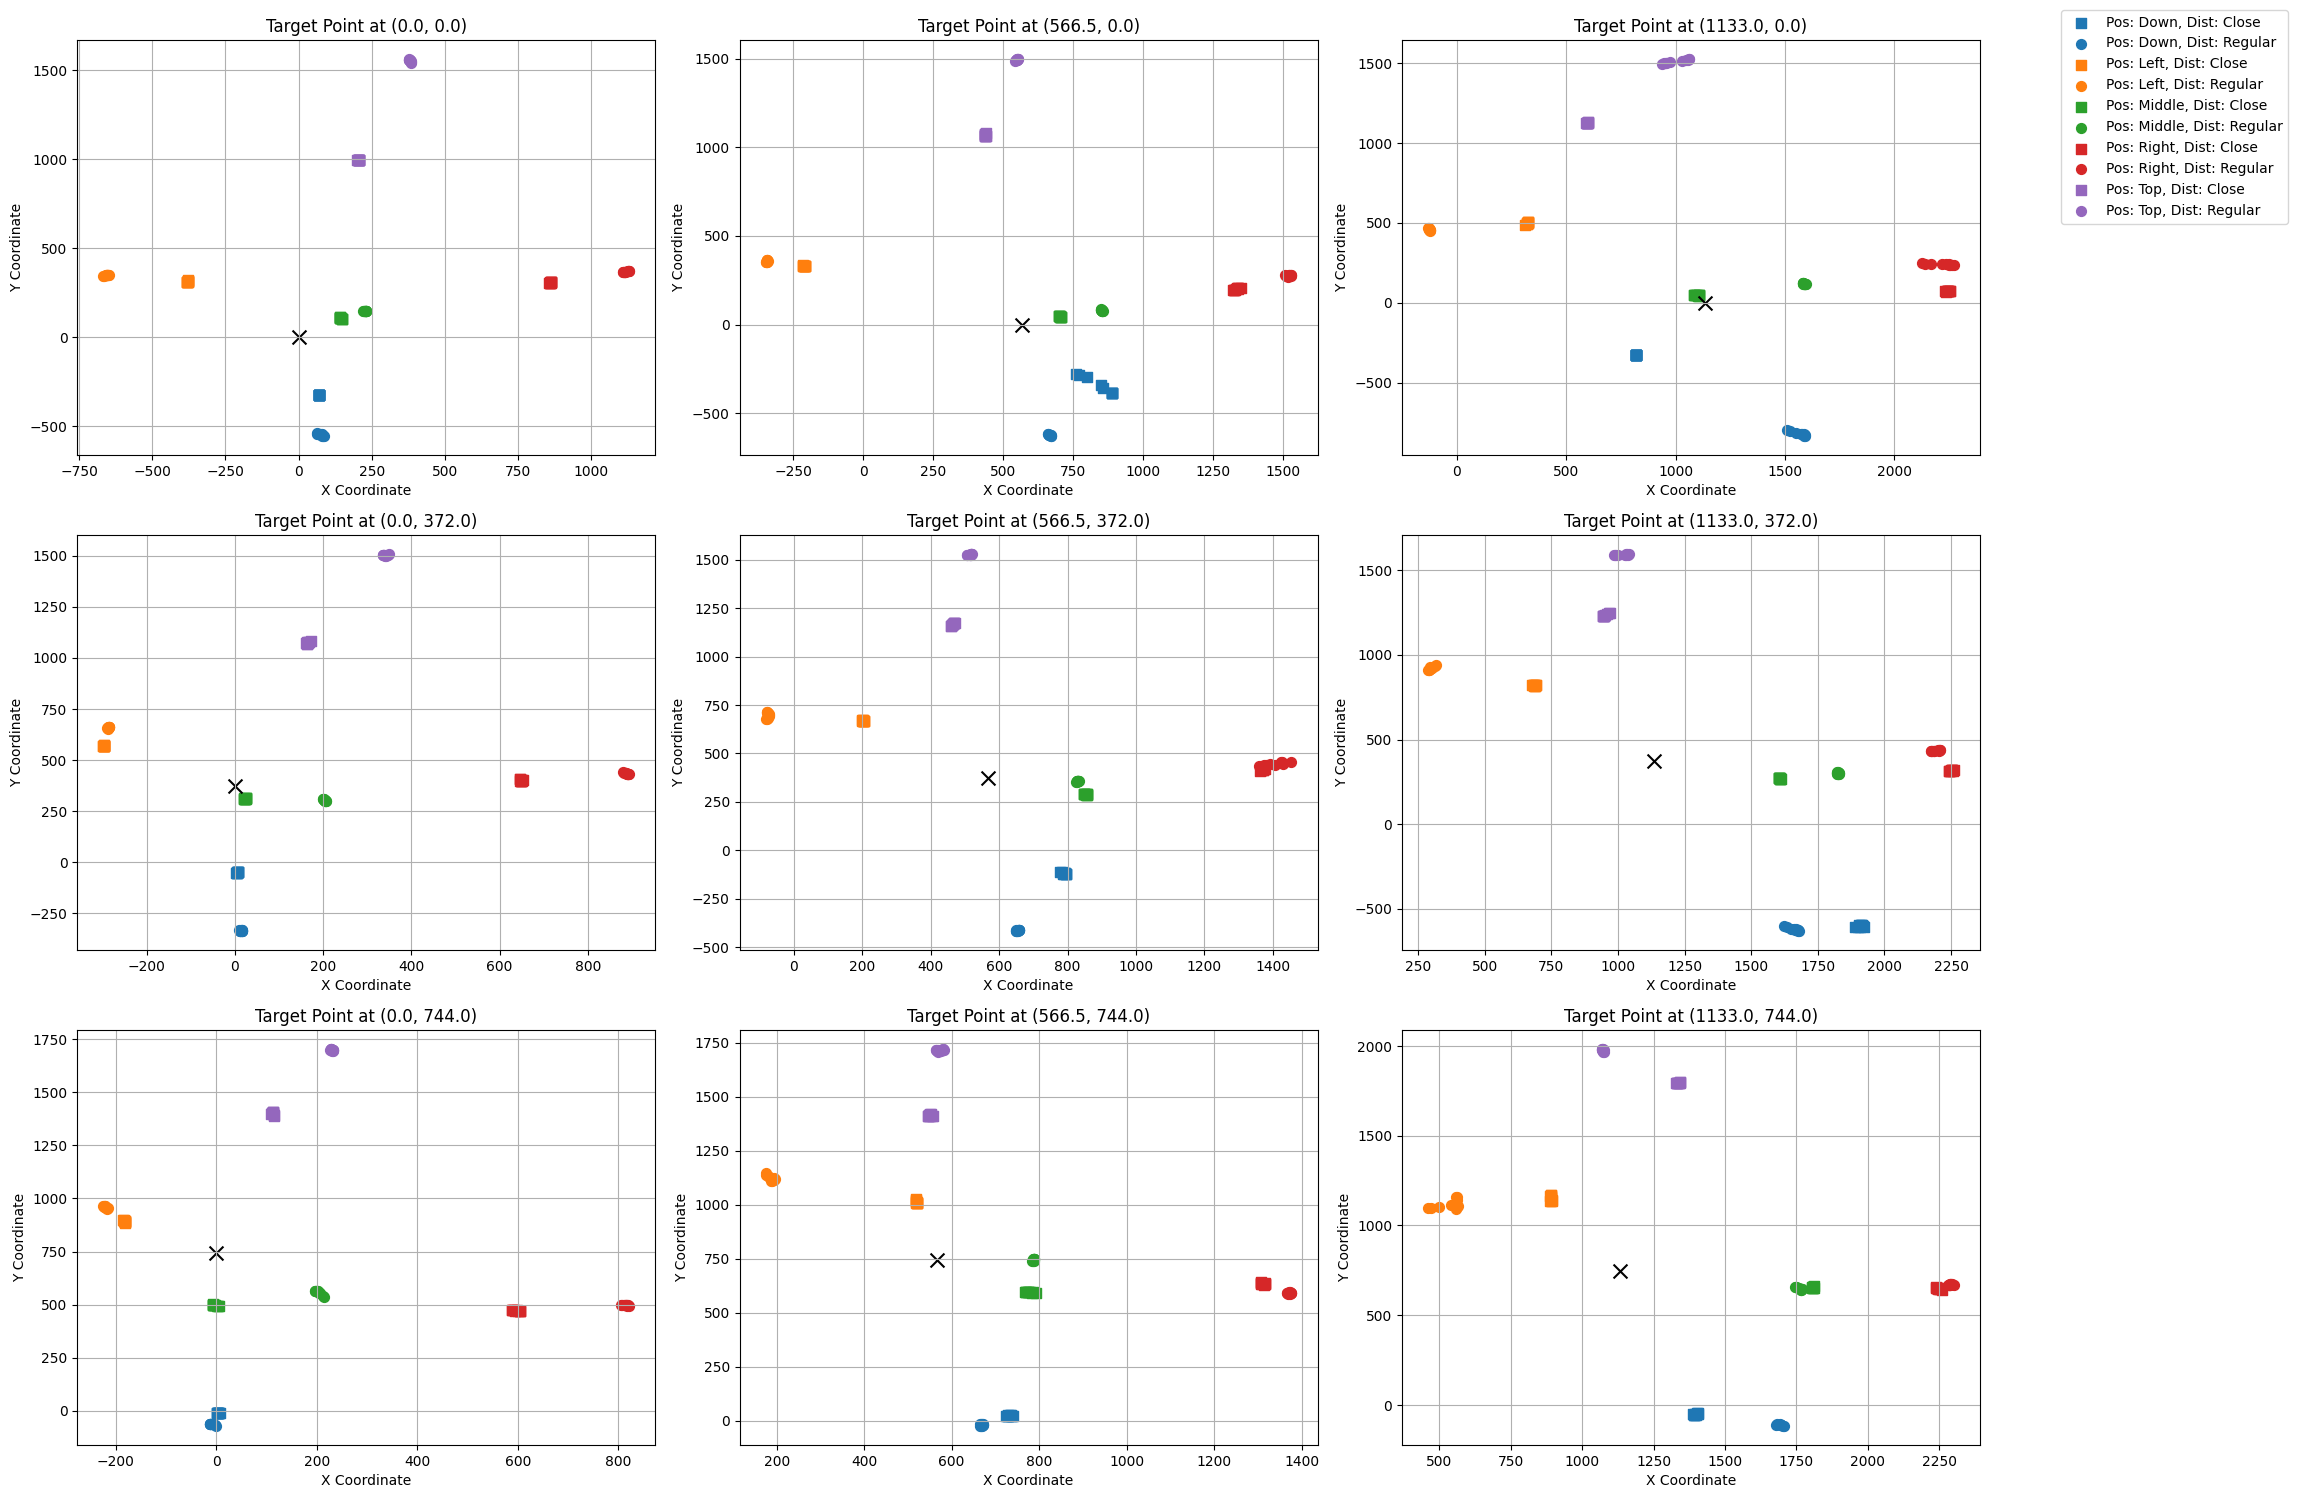

In [6]:
show_subplots(df)

In [7]:
calib_data = import_from_dataframe(df)
print(calib_data[0])

CalibrationData(username='victor', device_name='iPad Mini 6th', position=<HeadPosition.MIDDLE: 'Middle'>, distance=<PositionToScreen.REGULAR: 'Regular'>, timestamp=1715694046.711232, target_point=(0.0, 0.0), gaze_point=(229.15064203222903, 146.01430109941114), face_transform=array([[ 0.9999205 , -0.0044637 , -0.01179334,  0.        ],
       [ 0.0041845 ,  0.99971294, -0.02359388,  0.        ],
       [ 0.01189532,  0.02354266,  0.99965197,  0.        ],
       [ 0.06862871, -0.00328225, -0.38051197,  1.        ]]), right_eye_transform=array([[ 0.99653846, -0.01076515,  0.08243386,  0.        ],
       [ 0.        ,  0.9915805 ,  0.12949182,  0.        ],
       [-0.08313381, -0.12904358,  0.9881481 ,  0.        ],
       [-0.03144449,  0.03050292,  0.0254751 ,  1.        ]]), left_eye_transform=array([[ 0.9885571 , -0.01938766,  0.14959574,  0.        ],
       [ 0.        ,  0.99170613,  0.12852542,  0.        ],
       [-0.15084684, -0.12705474,  0.9803582 ,  0.        ],
       [ 0

In [15]:
grouped_data = group_data(df)
print("Grouped dataframe size:", grouped_data.shape)
display(grouped_data.head())

Grouped dataframe size: (90, 63)


,username,deviceName,position,distance,targetPointX,targetPointY,timestamp,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w,lookAtPointX,lookAtPointY,lookAtPointZ,roll,pitch,yaw
0,victor,iPad Mini 6th,Down,Close,0.0,0.0,1.715694e+09,70.988760,-324.538195,0.998787,...,0.031738,0.029988,0.024180,1.0,-0.207724,0.145160,0.870479,-19.190293,1.007004,-2.635080
1,victor,iPad Mini 6th,Down,Close,0.0,372.0,1.715694e+09,5.810137,-48.642838,0.998952,...,0.032182,0.031637,0.023821,1.0,-0.212063,0.074501,0.836008,-10.586718,2.618074,-0.141696
2,victor,iPad Mini 6th,Down,Close,0.0,744.0,1.715694e+09,3.500565,-9.812429,0.997390,...,0.032198,0.031979,0.023494,1.0,-0.197576,0.160285,0.890163,-12.971371,4.016960,0.998458
3,victor,iPad Mini 6th,Down,Close,566.5,0.0,1.715694e+09,873.400326,-371.883272,0.999518,...,0.031631,0.028292,0.024956,1.0,0.112326,0.096527,0.742844,-19.847600,-0.524636,-1.707931
4,victor,iPad Mini 6th,Down,Close,566.5,372.0,1.715694e+09,791.603750,-119.648882,0.998964,...,0.032214,0.031813,0.023788,1.0,0.117347,0.118060,0.841723,-14.116672,2.550149,0.581315


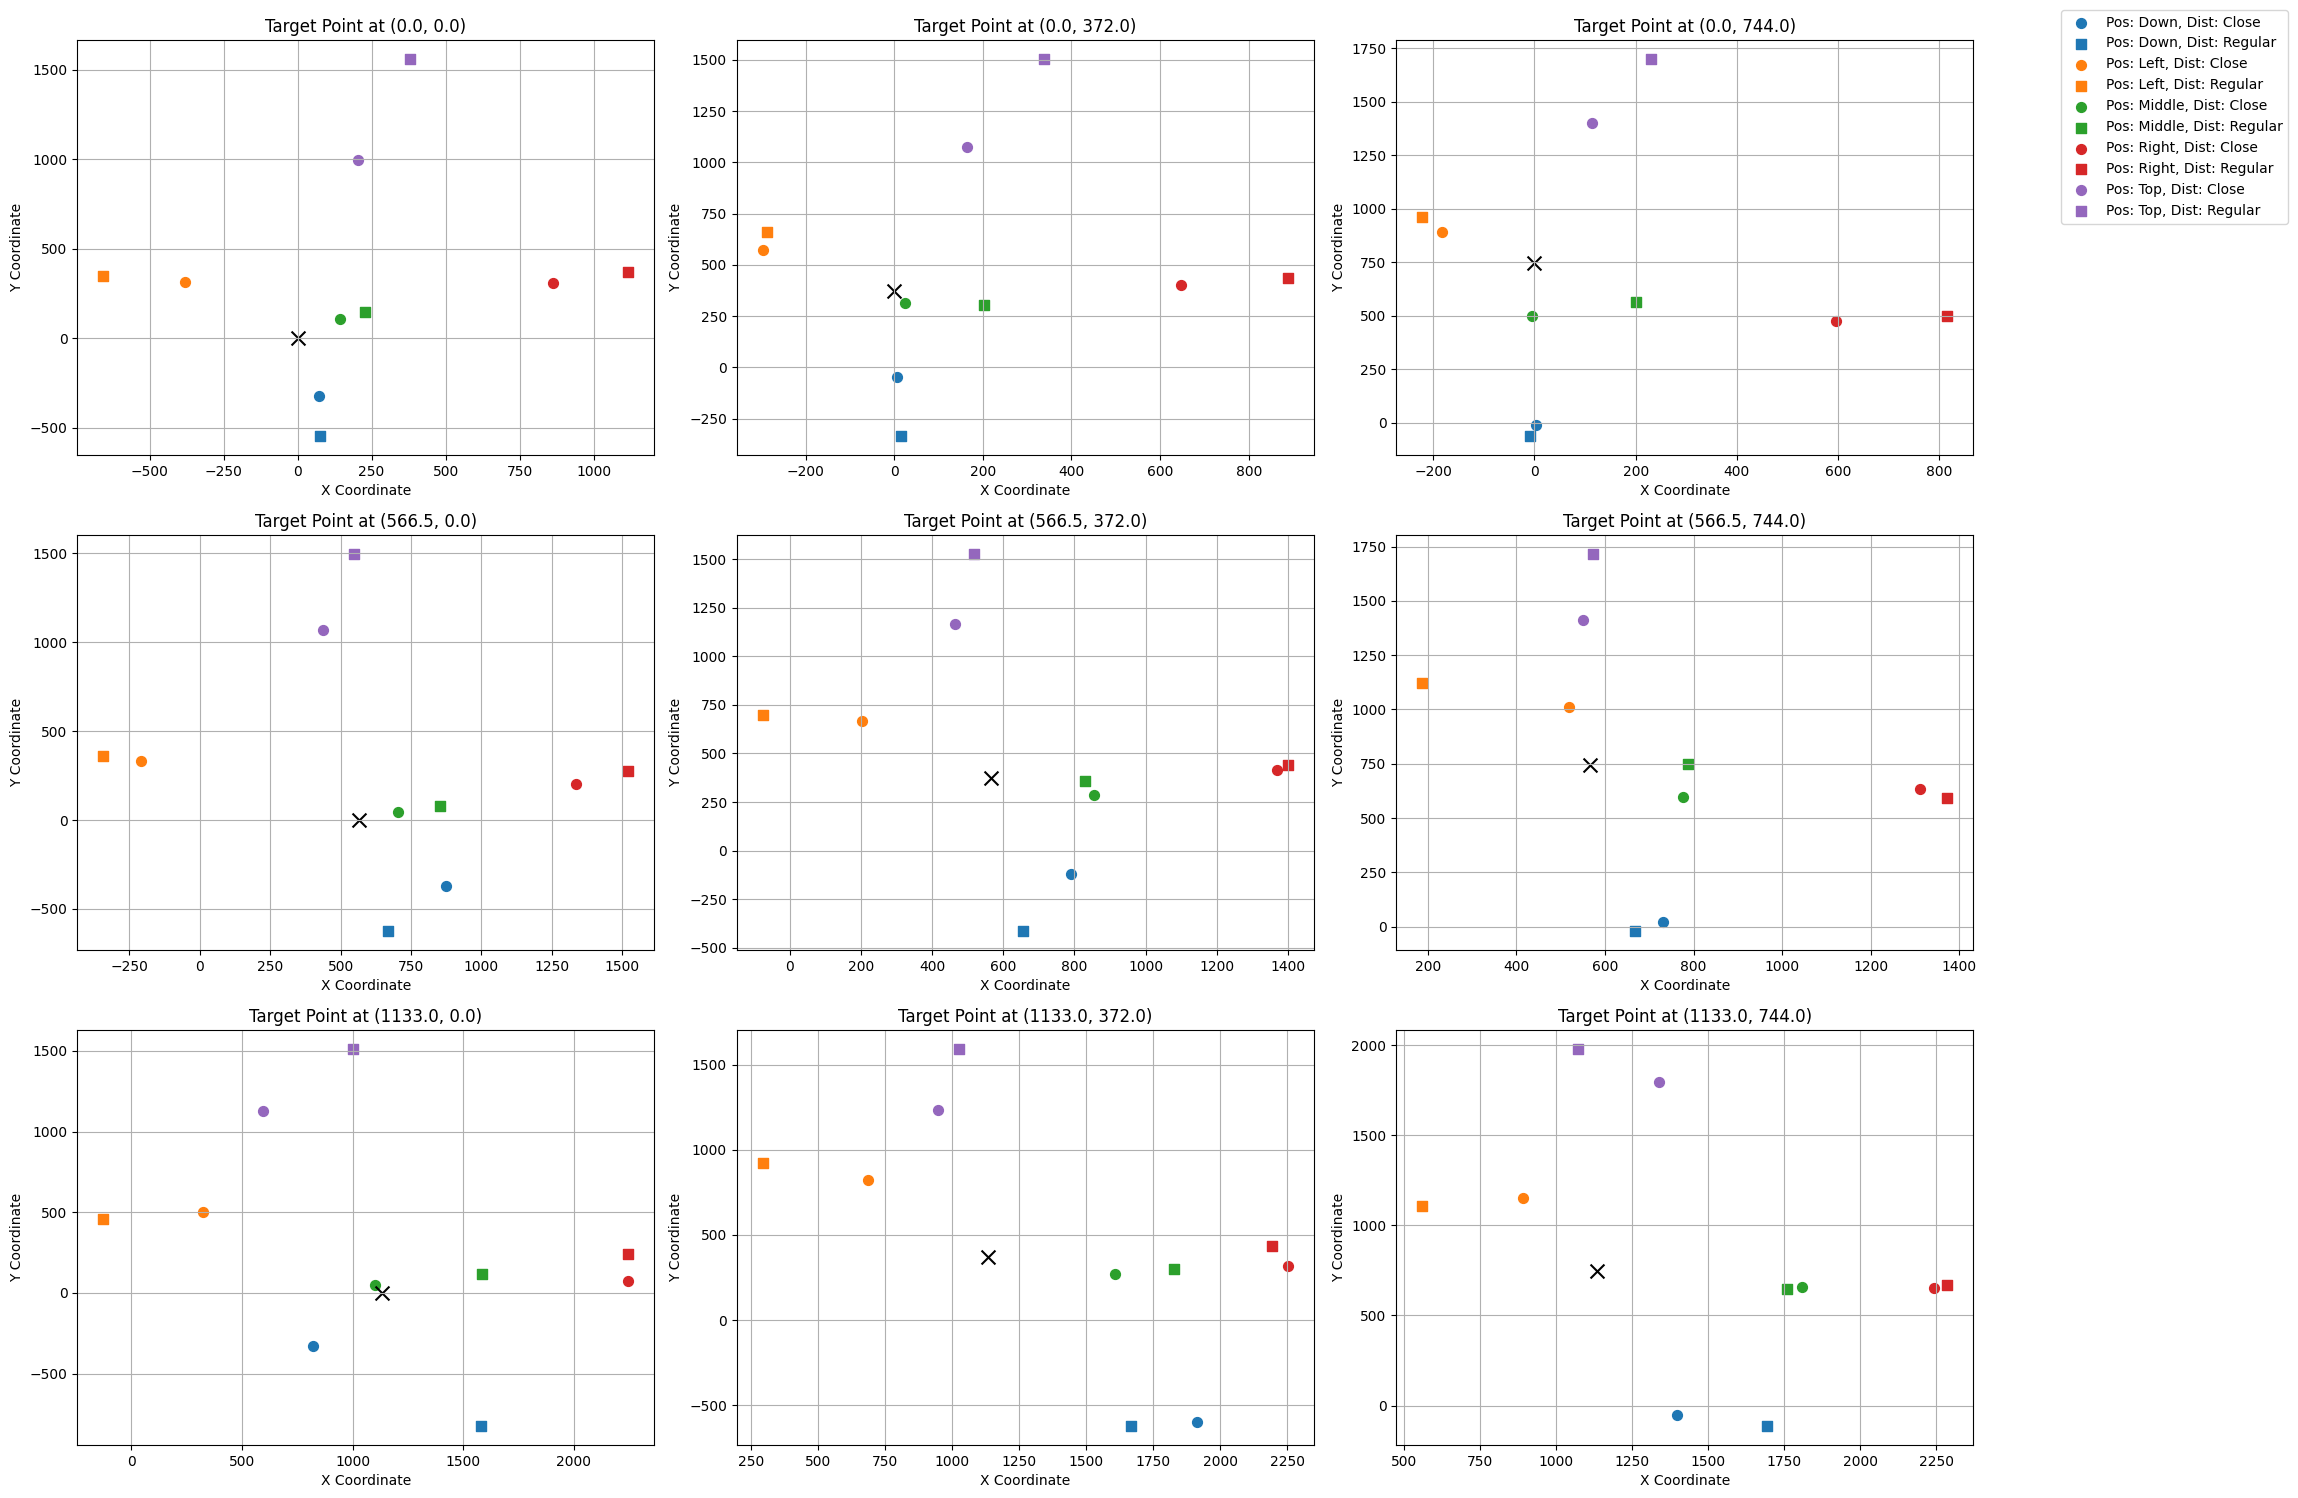

In [13]:
show_subplots(grouped_data)

Now we are going to create 10 different splits of train and test data.

In [ ]:
splits = [create_split(calib_data) for _ in range(5)]